In [120]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plot
import matplotlib as mpl
import pycaret.classification as pycaret_classification

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import log_loss, f1_score, roc_curve, auc, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import seaborn as sns

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

# Configurar o MLFLOW

In [3]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Lançamentos do Kobe Bryant'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/Users/rafael/dev/workspaces/infnet/pos-ai/machine-learning-engeneering/projeto-final-ml-eng/code/mlruns/1', creation_time=1712428469138, experiment_id='1', last_update_time=1712428469138, lifecycle_stage='active', name='Lançamentos do Kobe Bryant', tags={}>

# Preparação e análise do experimento

## Processa os dados de entrada

In [129]:
# Essas são as colunas que serão usadas nos experimentos a seguir
colunas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
colunas_sem_alvo = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance']
coluna_alvo= 'shot_made_flag'

percentual_treinamento = 0.8

dataframe_dev = None
dataframe_dev_treino = None
dataframe_dev_teste = None

#Começa o experimento
with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados', nested=True):  
    dataframe_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    # Remove as linhas com campos nulos e copia o dataframe resultante selecionando apenas as colunas importantes para o experimento.
    dataframe_dev = dataframe_dev.dropna()
    dataframe_dev = dataframe_dev[colunas].copy()

    dataframe_dev.to_parquet('../data/processed/data_filtered.parquet')

    xtrain, xtest, ytrain, ytest = train_test_split(dataframe_dev[colunas_sem_alvo], 
                                                    dataframe_dev[coluna_alvo], 
                                                    train_size=percentual_treinamento, 
                                                    stratify=dataframe_dev[coluna_alvo]
                                                   )

    xtrain[coluna_alvo] = ytrain
    xtest[coluna_alvo] = ytest
    
    dataframe_dev_treino = xtrain.copy()
    dataframe_dev_teste = xtest.copy()
    
    # Exporta bases de treino e teste
    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')
    
    mlflow.log_params({
        'percentual_teste': 1-percentual_treinamento,
        'colunas-selecionadas': colunas
    })
    mlflow.log_metrics({
        'quantidade_linhas_treino': xtrain.shape[0],
        'quantidade_linhas_teste': xtest.shape[0]
    })
    
mlflow_run = mlflow.active_run()


In [68]:
# configura pycaret
experiment = pycaret_classification.setup(
    data = xtrain, 
    target = coluna_alvo, 
    test_data = xtest, 
    normalize = True, 
    log_experiment = False
)

# Os modelos utilizados são regressão logística (lr) e árvore de decisão (dt)
modelos_utilizados = ['lr', 'dt']

list_models = experiment.compare_models(modelos_utilizados, n_select = 2)

list_models

,Description,Value
0,Session id,8431
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5770,0.6000,0.4907,0.5656,0.5254,0.1473,0.1485,0.0120
dt,Decision Tree Classifier,0.5355,0.5153,0.5856,0.5117,0.5461,0.0749,0.0756,0.0150


[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=8431, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_state=8431, splitter='best')]

## Analise da distribuição de dados:

In [70]:
clean_xtrain = xtrain.drop(coluna_alvo, axis=1)
clean_xtest = xtest.drop(coluna_alvo, axis=1)
df_train = clean_xtrain.copy()
df_test = clean_xtest.copy()

# Dados de treinamento
df_train['lr' ] = list_models[0].predict_proba(clean_xtrain)[:,1]
df_train['dt'] = list_models[1].predict_proba(clean_xtrain)[:,1]
df_train['shot_made_flag'] = ytrain

# dados de teste
df_test['lr' ] = list_models[0].predict_proba(clean_xtest)[:,1]
df_test['dt'] = list_models[1].predict_proba(clean_xtest)[:,1]
df_test['shot_made_flag'] = ytest

df_modelo_lancamento = pd.concat((df_train, df_test)).reset_index(drop=True)
print(df_modelo_lancamento.shape)
print(df_modelo_lancamento.head())

(20285, 9)
       lat       lon  minutes_remaining  period  playoffs  shot_distance  \
0  33.8933 -118.3208                  5       2         1             15   
1  33.8953 -118.1968                  4       1         0             16   
2  34.0303 -118.2578                  7       4         0              1   
3  33.9783 -118.2648                  9       3         1              6   
4  33.9093 -118.1618                  3       3         0             17   

         lr   dt  shot_made_flag  
0  0.000011  1.0             1.0  
1  0.000007  1.0             1.0  
2  0.004497  0.0             1.0  
3  0.000572  1.0             0.0  
4  0.000004  1.0             0.0  


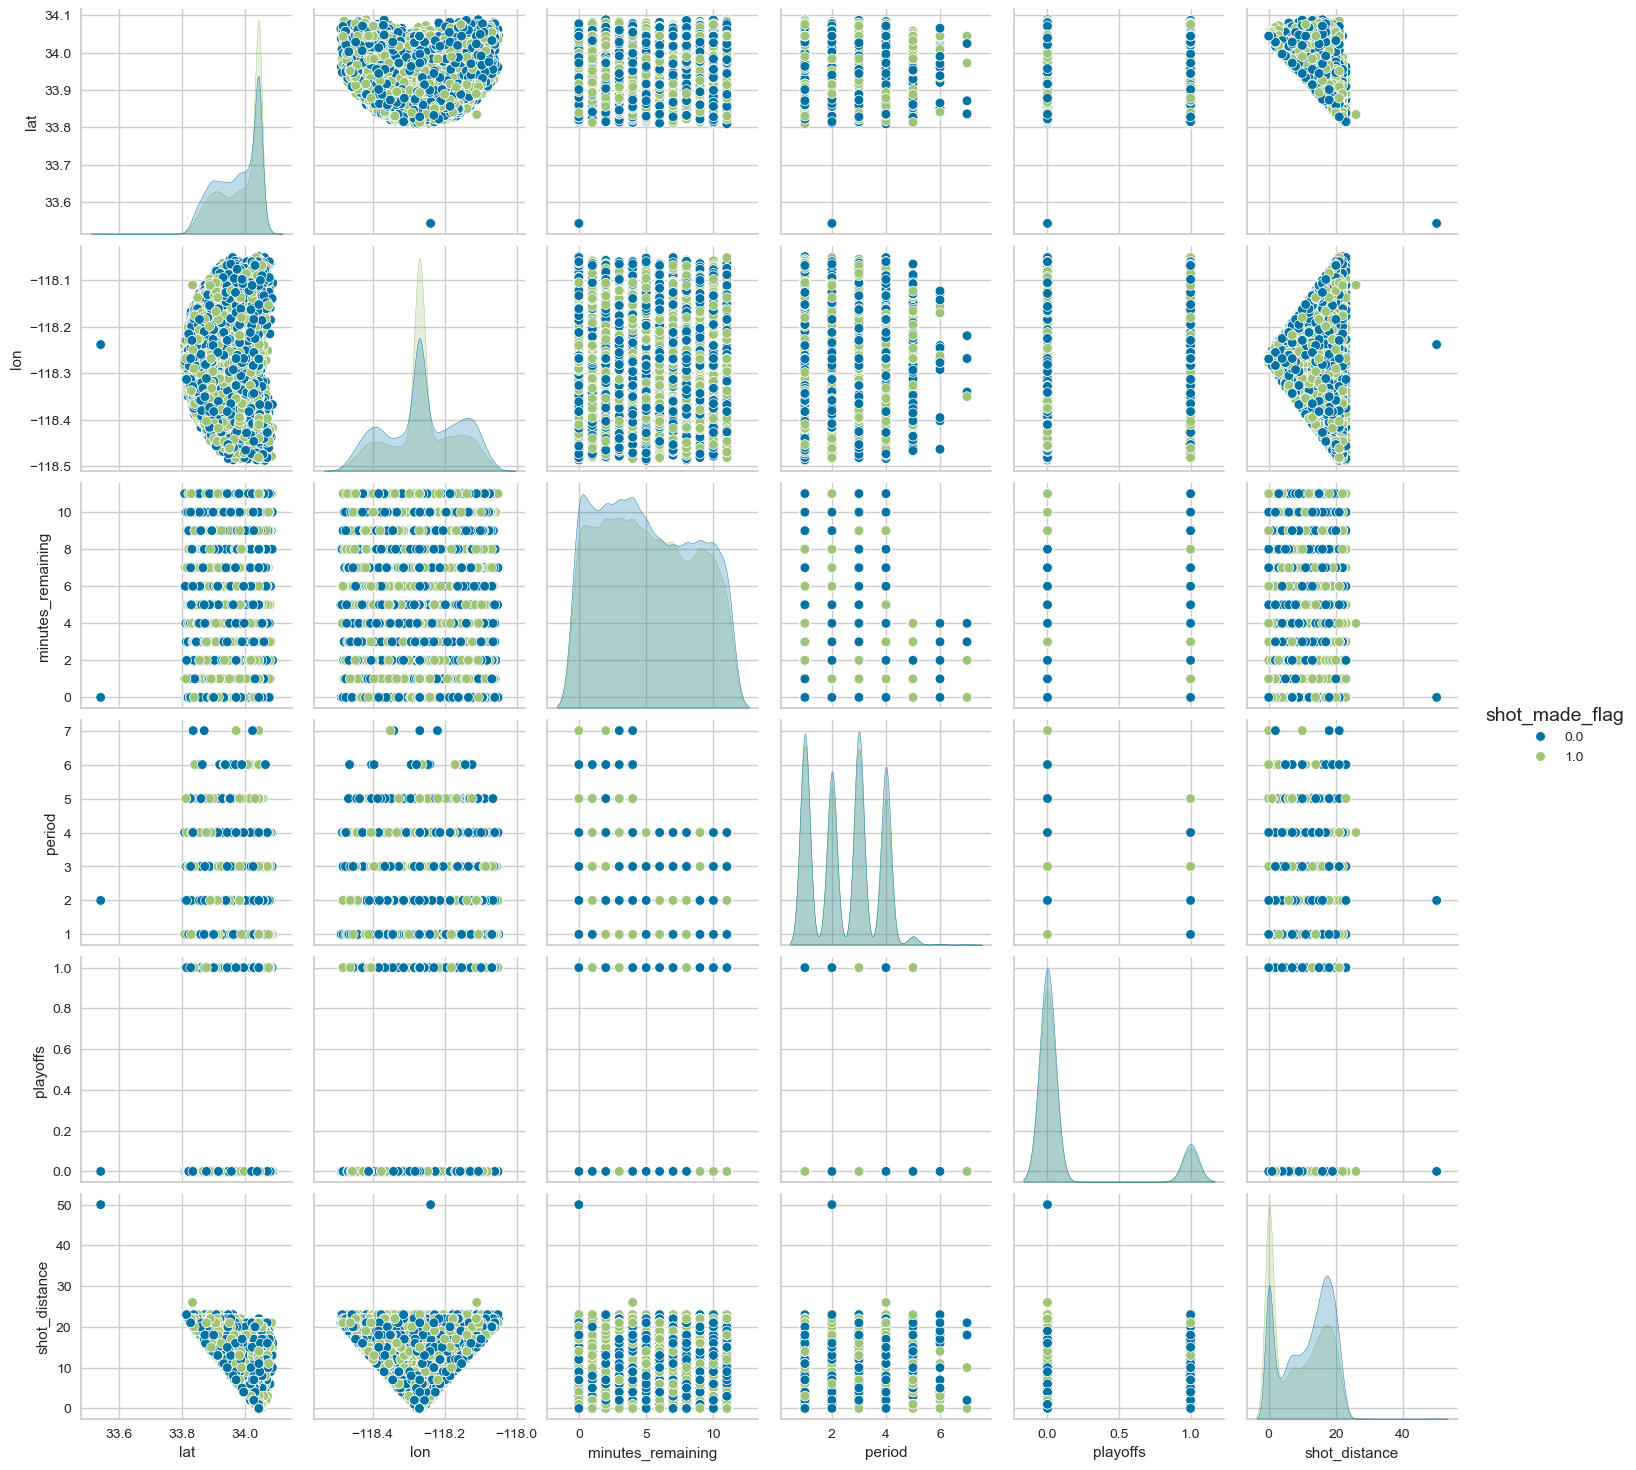

In [131]:
sns.pairplot(dataframe_dev[colunas], hue=coluna_alvo)
plot.show()

## Análise da variável que parece ser mais importante

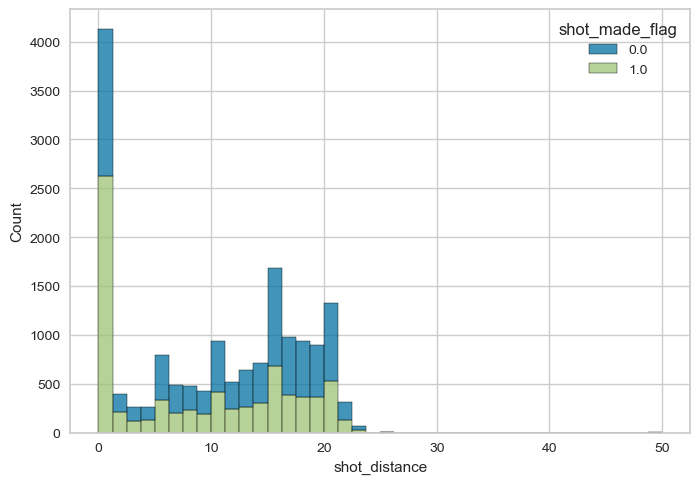

In [72]:
sns.histplot(data=df_train, x='shot_distance', hue=coluna_alvo, multiple="stack")
plot.show()

## Comparação de dados de treino e teste

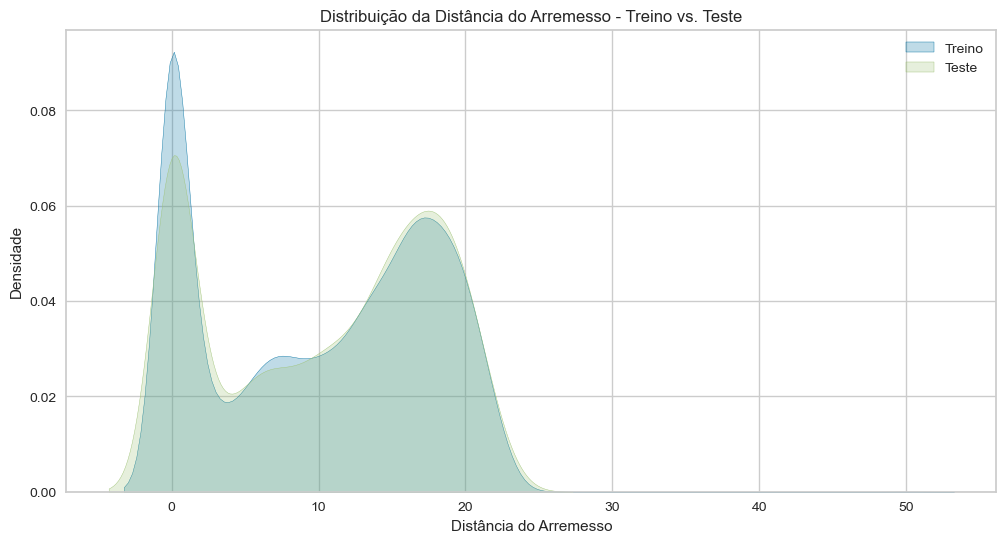

In [74]:
# Plot da distribuição de 'shot_distance' para treino e teste
plot.figure(figsize=(12, 6))
sns.kdeplot(df_train['shot_distance'], label='Treino', shade=True)
sns.kdeplot(df_test['shot_distance'], label='Teste', shade=True)
plot.title('Distribuição da Distância do Arremesso - Treino vs. Teste')
plot.xlabel('Distância do Arremesso')
plot.ylabel('Densidade')
plot.legend()
plot.show()

In [80]:
# Criar uma tabela comparativa
df_comparacao = pd.DataFrame({
    'Conjunto': ['Treino', 'Teste'],
    'Número de Amostras': [df_train.shape[0], df_train.shape[0]],
    'Média de Distância de Arremesso': [df_train['shot_distance'].mean(), df_test['shot_distance'].mean()],
    'Desvio Padrão': [df_train['shot_distance'].std(), df_test['shot_distance'].std()],
    'Mínimo': [df_train['shot_distance'].min(), df_test['shot_distance'].min()],
    'Máximo': [df_train['shot_distance'].max(), df_test['shot_distance'].max()]
})

print(df_comparacao)

  Conjunto  Número de Amostras  Média de Distância de Arremesso  \
0   Treino               16228                        10.168782   
1    Teste               16228                        10.406458   

   Desvio Padrão  Mínimo  Máximo  
0       7.565065       0      50  
1       7.535366       0      23  


## Configura o pycaret

In [83]:
# plot com a validation curve "vc" e salva a imagem
experiment.plot_model(list_models[0], plot='vc', save = True)

# Cria função para plotar a calidation curve especificando o parametro
def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plot.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plot.title("Curva Validação Modelo " + model_name)
    plot.xlabel(param_name)
    plot.ylabel("Score ("+scoring+")")
    if logx:
        plot.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plot.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plot.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plot.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plot.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plot.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plot.legend(loc='best')
    plot.grid(True)
    
    image = plot.gcf()
    image_name = 'validation_curve' + '_' + model_name + '_' + param_name + '.png'
    image.savefig(image_name, dpi=100)
    plot.show()
    return image_name


## Registra regressão logistica

In [133]:
yhat_test = experiment.predict_model(list_models[0])

modelo_dev_teste = yhat_test.copy()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5763,0.5930,0.4750,0.5672,0.5170,0.1448,0.1467


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


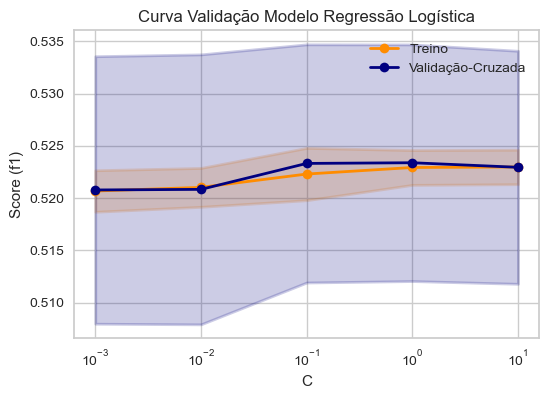

In [89]:
image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]}, list_models[0], 'Regressão Logística', 'f1', logx=True)

active_run = mlflow.active_run()
if not active_run:
    active_run = mlflow.start_run()

mlflow.log_artifact(image_name, run_id=active_run.info.run_id)

os.remove(image_name)

mlflow.log_metrics({
'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

# Registra árvore de decisão

In [91]:
yhat_test = experiment.predict_model(list_models[1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5519,0.5354,0.5911,0.5274,0.5574,0.1066,0.1073


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


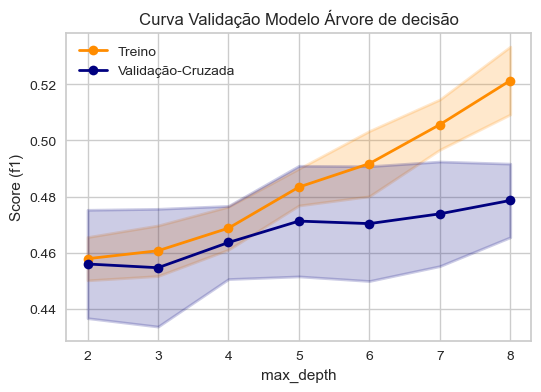

In [93]:
image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]}, list_models[1], 'Árvore de decisão', 'f1', logx=False)

mlflow.log_artifact(image_name)

os.remove(image_name)

mlflow.log_metrics({
'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

## Curva ROC e AUC

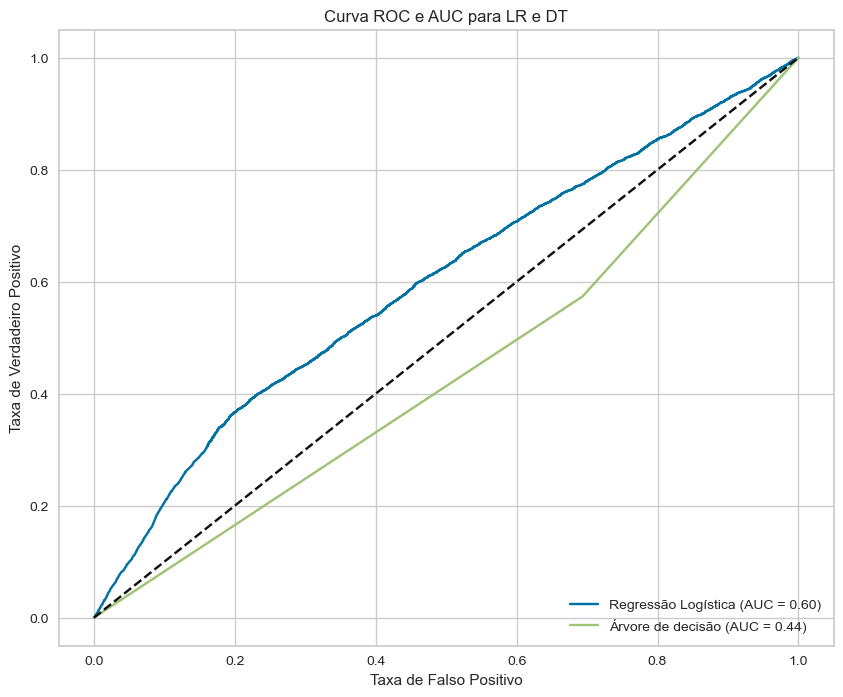

In [95]:
clean_xtrain = xtrain.drop(coluna_alvo, axis=1)
clean_xtest = xtest.drop(coluna_alvo, axis=1)

# Regressão Logistica
logistic_scores = list_models[0].predict_proba(clean_xtrain)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(ytrain, logistic_scores)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Arvore de Decisão
tree_scores = list_models[1].predict_proba(clean_xtrain)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(ytrain, tree_scores)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Plot curva ROC e AUC (area under the curve)
plot.figure(figsize=(10, 8))
plot.plot(fpr_logistic, tpr_logistic, label=f'Regressão Logística (AUC = {roc_auc_logistic:.2f})')
plot.plot(fpr_tree, tpr_tree, label=f'Árvore de decisão (AUC = {roc_auc_tree:.2f})')
plot.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plot.xlabel('Taxa de Falso Positivo')
plot.ylabel('Taxa de Verdadeiro Positivo')
plot.title('Curva ROC e AUC para LR e DT')
plot.legend(loc="lower right")

image = plot.gcf()
image_name = 'ROC_curve_AUC.png'
image.savefig(image_name, dpi=100)
    
plot.show()

mlflow.log_artifact(image_name)

os.remove(image_name)

## Matriz de confusão

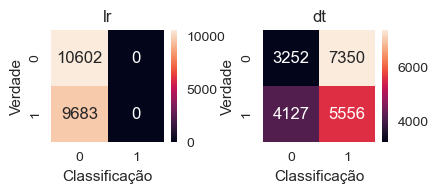

In [97]:
plot.figure(figsize=(10,8))

for i, modelo in enumerate(list_models):
    # Numero de linas e colunas para o subplot
    plot.subplot(4, 4, i+1) 
    plot.subplots_adjust(wspace=.5, hspace=0.5)
    label_modelo = 'dt'
    if isinstance(modelo, LogisticRegression):
        label_modelo = 'lr'
    
    cm = metrics.confusion_matrix(df_modelo_lancamento['shot_made_flag'],
                                  df_modelo_lancamento[label_modelo] > 0.5)
    
    sns.heatmap(cm, annot=True, fmt = '.0f')
    
    plot.title(label_modelo)
    plot.xlabel('Classificação')
    plot.ylabel('Verdade')


# Treinamento do modelo

In [99]:
# Função para plotar e salvar a matriz de confusão
def save_confusion_matrix(cm, model_name):
    plot.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d")
    plot.title(f'Matriz de Confusão - {model_name}')
    plot.xlabel('Predito')
    plot.ylabel('Verdadeiro')
    
    #image_name = f'confusion_matrix_{model_name}.png'
    #plot.savefig(image_name)
    #plot.close()  # Fechar a figura para não exibir no notebook
    #log_artifact(image_name)  # Logar a imagem no MLflow
    #os.remove(image_name)  # Remover a imagem para limpar o diretório
    
    
    image = plot.gcf()
    image_name = f'confusion_matrix_{model_name}.png'
    image.savefig(image_name, dpi=100)
    plot.show()
    return image_name

In [137]:
mlflow.end_run()

,Description,Value
0,Session id,1460
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5773,0.5998,0.4893,0.5660,0.5247,0.1478,0.1491,0.0130
dt,Decision Tree Classifier,0.5440,0.5238,0.5834,0.5199,0.5498,0.0909,0.0916,0.0160


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5783,0.5964,0.4843,0.5685,0.5230,0.1494,0.1509


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


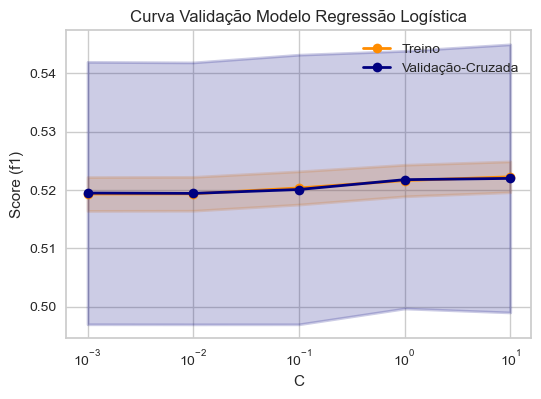

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5309,0.5142,0.5782,0.5077,0.5407,0.0656,0.0661


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


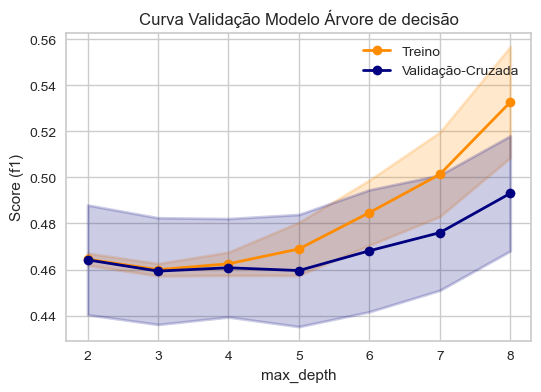

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6007,0.6320,0.5633,0.5845,0.5737,0.1985,0.1986
1,0.5890,0.6112,0.5891,0.5665,0.5776,0.1778,0.1779
2,0.5736,0.5945,0.5303,0.5562,0.5429,0.1438,0.1440
3,0.5823,0.6029,0.5497,0.5642,0.5569,0.1619,0.1619
4,0.5884,0.6325,0.5665,0.5694,0.5679,0.1750,0.1750
5,0.5564,0.5908,0.5355,0.5355,0.5355,0.1110,0.1110
6,0.5508,0.5712,0.4994,0.5316,0.5150,0.0975,0.0977
7,0.5650,0.5828,0.5445,0.5445,0.5445,0.1282,0.1282
8,0.5647,0.5873,0.5207,0.5461,0.5331,0.1259,0.1260


Fitting 10 folds for each of 4 candidates, totalling 40 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5719,0.5964,0.5359,0.5533,0.5445,0.1408,0.1409


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_kobe' already exists. Creating a new version of this model...
Created version '27' of model 'modelo_kobe'.


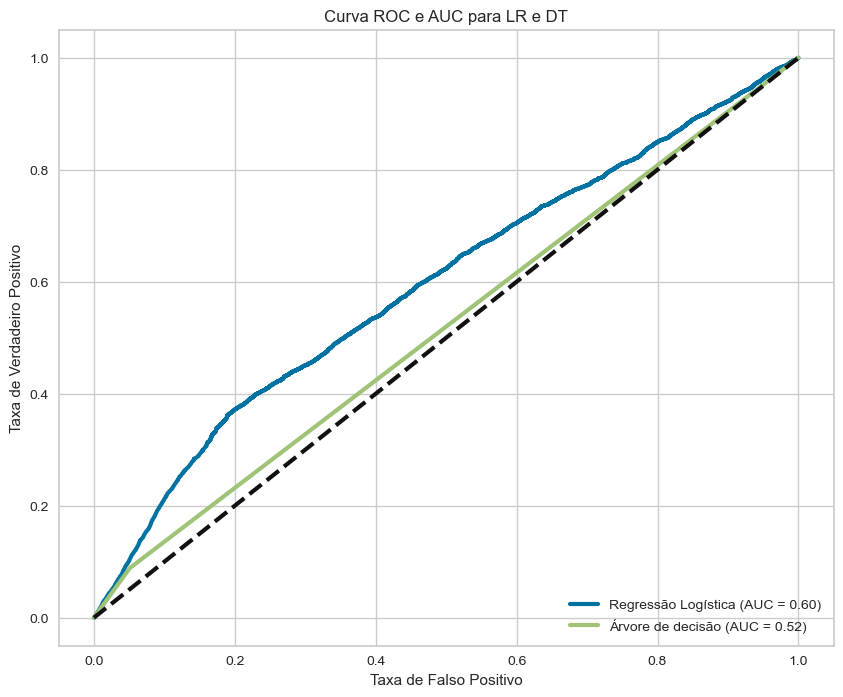

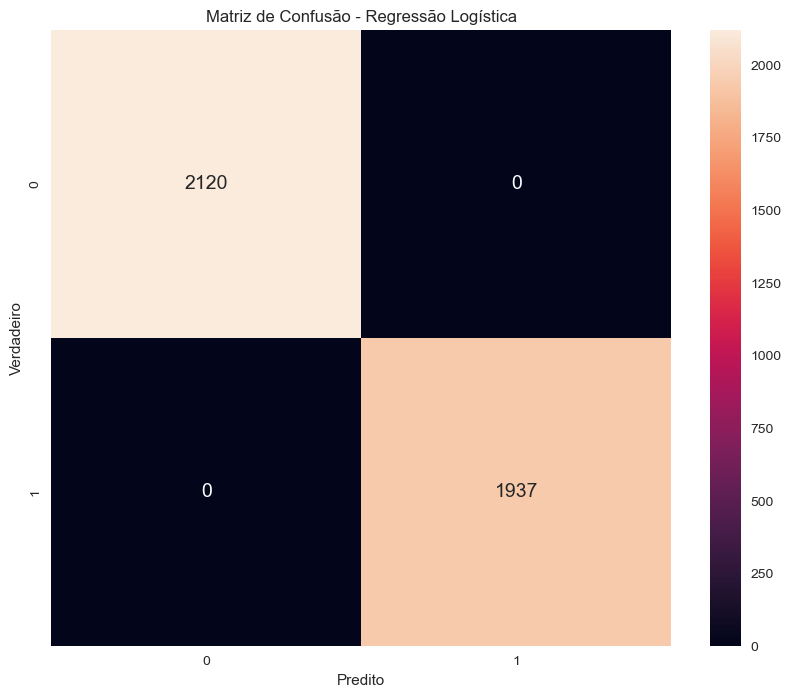

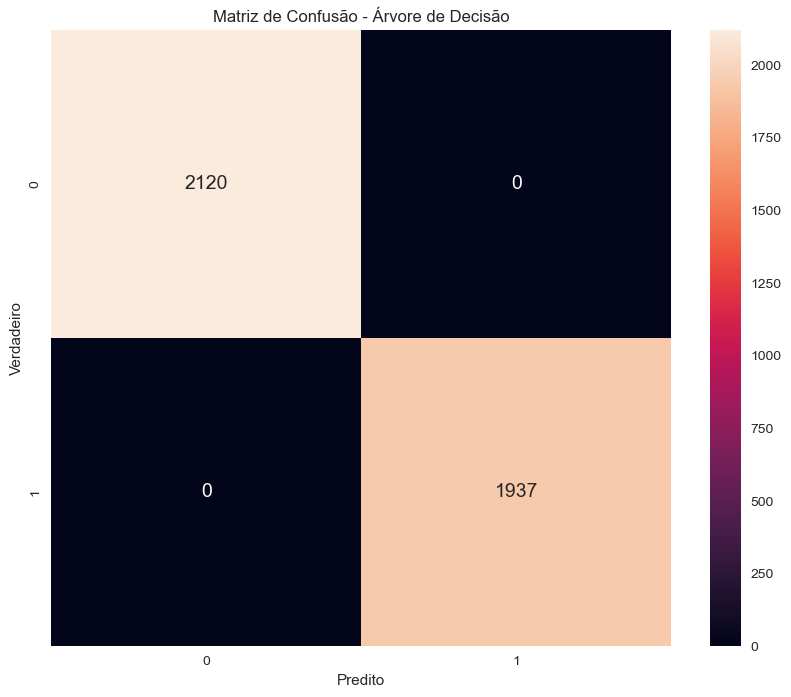

In [148]:
registered_model_name = 'modelo_kobe'
nexamples = 5
model_version = -1

arquivo_previsao = '../data/processed/prediction_test.parquet'
with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    # configura pycaret
    experiment = pycaret_classification.setup(
        data = xtrain, 
        target = coluna_alvo, 
        test_data = xtest, 
        normalize = True, 
        log_experiment = False
    )

    # Os modelos utilizados são regressão logística (lr) e árvore de decisão (dt)
    modelos_utilizados = ['lr', 'dt']

    list_models = experiment.compare_models(modelos_utilizados, n_select = 2)

    list_models
    
    # Regressão Logística
    yhat_test = experiment.predict_model(list_models[0])
    yhat_test_lr = yhat_test
    modelo_prod_teste = yhat_test.copy()
    lr_image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]}, list_models[0], 'Regressão Logística', 'f1', logx=True)

    mlflow.log_artifact(lr_image_name)

    os.remove(lr_image_name)

    mlflow.log_metrics({
    'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    # Árvore de decisão
    yhat_test = experiment.predict_model(list_models[1])
    yhat_test_dt = yhat_test
    
    dt_image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]}, list_models[1], 'Árvore de decisão', 'f1', logx=False)

    mlflow.log_artifact(dt_image_name)

    os.remove(dt_image_name)

    mlflow.log_metrics({
    'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    # Finaliza o melhor modelo ( Regressão Logística)
    tune_model = experiment.tune_model(list_models[0], optimize = 'f1', search_library = 'scikit-learn', search_algorithm = 'random',  n_iter = 4)
    
    yhat_test = experiment.predict_model(tune_model, raw_score=True)
    modelo_prod_teste_tuned = yhat_test.copy()
    mlflow.log_metrics({
    'final_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'final_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    prediction_test_file = '../data/processed/prediction_test.parquet'
    yhat_test.to_parquet(prediction_test_file)

    mlflow.log_artifact(prediction_test_file)
    
    final_model = experiment.finalize_model(tune_model)

    # EXPORTA PARA LOG E REGISTRO DO MODELO FINAL

    registered_model_name = 'modelo_kobe'
    nexamples = 5

    experiment.save_model(final_model, f'./{registered_model_name}') 

    # Carrega novamente o pipeline + bestmodel
    model_pipe = experiment.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow

    model_features = list(xtrain.drop(coluna_alvo, axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], model_pipe.predict(xtrain.drop(coluna_alvo, axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name=registered_model_name,
        version=model_version, # Verificar com usuario qual versao
        alias="staging"
    )
    
    # Curva ROC e AUC
    
    clean_xtrain = xtrain.drop(coluna_alvo, axis=1)
    clean_xtest = xtest.drop(coluna_alvo, axis=1)

    # Regressão Logistica
    logistic_scores = list_models[0].predict_proba(clean_xtrain)[:, 1]
    fpr_logistic, tpr_logistic, _ = roc_curve(ytrain, logistic_scores)
    roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

    # Arvore de Decisão
    tree_scores = list_models[1].predict_proba(clean_xtrain)[:, 1]
    fpr_tree, tpr_tree, _ = roc_curve(ytrain, tree_scores)
    roc_auc_tree = auc(fpr_tree, tpr_tree)

    # Plot curva ROC e AUC (area under the curve)
    plot.figure(figsize=(10, 8))
    plot.plot(fpr_logistic, tpr_logistic, label=f'Regressão Logística (AUC = {roc_auc_logistic:.2f})')
    plot.plot(fpr_tree, tpr_tree, label=f'Árvore de decisão (AUC = {roc_auc_tree:.2f})')
    plot.plot([0, 1], [0, 1], 'k--')  # linha diagonal
    plot.xlabel('Taxa de Falso Positivo')
    plot.ylabel('Taxa de Verdadeiro Positivo')
    plot.title('Curva ROC e AUC para LR e DT')
    plot.legend(loc="lower right")

    image = plot.gcf()
    image_name = 'ROC_curve_AUC.png'
    image.savefig(image_name, dpi=100)

    plot.show()

    mlflow.log_artifact(image_name)

    os.remove(image_name)

    
    ## Matriz de confusão final
    
    # Calcule as matrizes de confusão
    # Gere e logue a matriz de confusão para o modelo de regressão logística
    cm_lr = confusion_matrix(ytest, yhat_test_lr.shot_made_flag)
    image_name = save_confusion_matrix(cm_lr, 'Regressão Logística')
    mlflow.log_artifact(image_name)
    os.remove(image_name)
    
    # Gere e logue a matriz de confusão para o modelo de árvore de decisão
    cm_dt = confusion_matrix(ytest, yhat_test_dt.shot_made_flag)
    image_name = save_confusion_matrix(cm_dt, 'Árvore de Decisão')
    mlflow.log_artifact(image_name)
    os.remove(image_name)


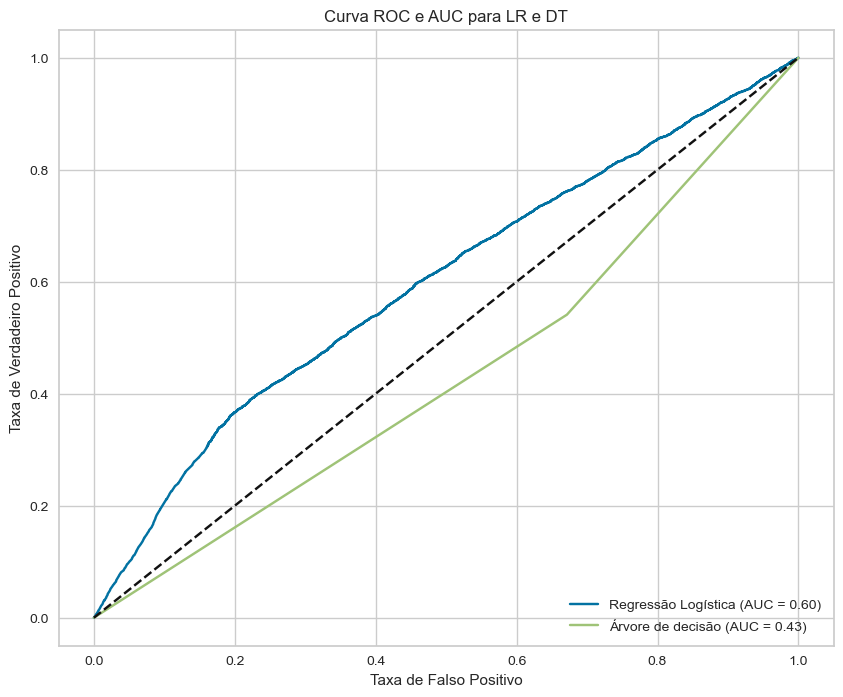

In [105]:
clean_xtrain = xtrain.drop(coluna_alvo, axis=1)
clean_xtest = xtest.drop(coluna_alvo, axis=1)

# Regressão Logistica
logistic_scores = list_models[0].predict_proba(clean_xtrain)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(ytrain, logistic_scores)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Arvore de Decisão
tree_scores = list_models[1].predict_proba(clean_xtrain)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(ytrain, tree_scores)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Plot curva ROC e AUC (area under the curve)
plot.figure(figsize=(10, 8))
plot.plot(fpr_logistic, tpr_logistic, label=f'Regressão Logística (AUC = {roc_auc_logistic:.2f})')
plot.plot(fpr_tree, tpr_tree, label=f'Árvore de decisão (AUC = {roc_auc_tree:.2f})')
plot.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plot.xlabel('Taxa de Falso Positivo')
plot.ylabel('Taxa de Verdadeiro Positivo')
plot.title('Curva ROC e AUC para LR e DT')
plot.legend(loc="lower right")

image = plot.gcf()
image_name = 'ROC_curve_AUC.png'
image.savefig(image_name, dpi=100)
    
plot.show()

mlflow.log_artifact(image_name)

os.remove(image_name)

In [107]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['lat', 'lon', 'minutes_remaining',
                                             'period', 'playoffs',
                                             'shot_distance'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_imp...
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('actual_estimator',
                 LogisticRegression(C=1.627, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=3714, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

## Configura Alarmes e monitoramento

#### Alarme de desvio

In [174]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_prod):
    plot.figure(figsize=(6,4))
    sns.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sns.kdeplot(data_test[var_name], label='Teste')
    sns.kdeplot(data_prod[var_name], label='Produção')
    plot.grid()
    plot.legend(loc='best')
    plot.title(f'Distribuição Variável {var_name}')
    plot.ylabel('Densidade')
    plot.xlabel(f'Unidade de {var_name}')
    plot.tight_layout()

#### Alarme de retreinamento

In [162]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[coluna_alvo], data_monitoring['prediction_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[coluna_alvo], testset['prediction_label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

#### Monitoramento base de produção

== ALARME DE RETREINAMENTO - BASE CONTROLE ==


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5783,0.5964,0.4843,0.5685,0.5230,0.1494,0.1509


	=> especificidade de teste 0.6641509433962264 e de controle 0.6047169811320755
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.48425400103252453 e de controle 0.535880227155395
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> precisao de teste 0.5684848484848485 e de controle 0.5533049040511727
	=> MODELO OPERANDO DENTRO DO ESPERADO
==> RETREINAMENTO NAO NECESSARIO


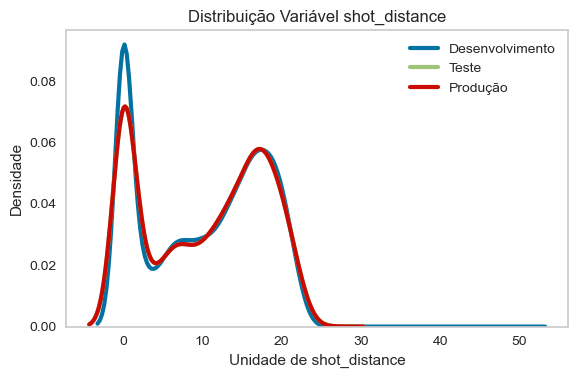

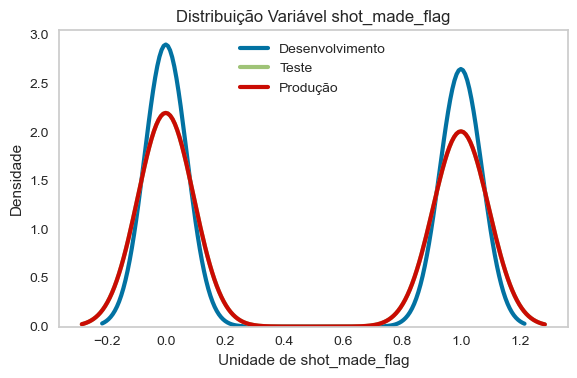

In [190]:
print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 
mlflow.end_run()
with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoTeste'):
    data_control = pd.read_parquet(arquivo_previsao)
    pred_holdout = pycaret_classification.predict_model(list_models[0], raw_score=True)
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'shot_distance'
    data_drift_alarm(var_name, dataframe_dev_treino, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plot.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    image = plot.gcf()
    image.savefig(plot_path, dpi=100)
    plot.show()
    os.remove(plot_path)
    
    # LOG ARTEFATO
    var_name = coluna_alvo
    data_drift_alarm(var_name, dataframe_dev_treino, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plot.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    image = plot.gcf()
    image.savefig(plot_path, dpi=100)
    plot.show()
    os.remove(plot_path)
    
    

mlflow.end_run()